In [25]:
#pip install opencv-python scikit-learn tensorflow matplotlib

# 1) Librerías y configuración

In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuraciones globales
IMG_SIZE = 224
DATA_DIR = "Dataset/"
CATEGORIES = os.listdir(DATA_DIR)

print(f"Categorías detectadas:\n")
for _ in CATEGORIES:
    print(_)

Categorías detectadas:

Anthracnose
Bacterial Blight
Citrus Canker
Curl Virus
Deficiency Leaf
Dry Leaf
Healthy Leaf
Sooty Mould
Spider Mites


# 2) Preprocesamiento con filtro Top-hat y Gaussiano

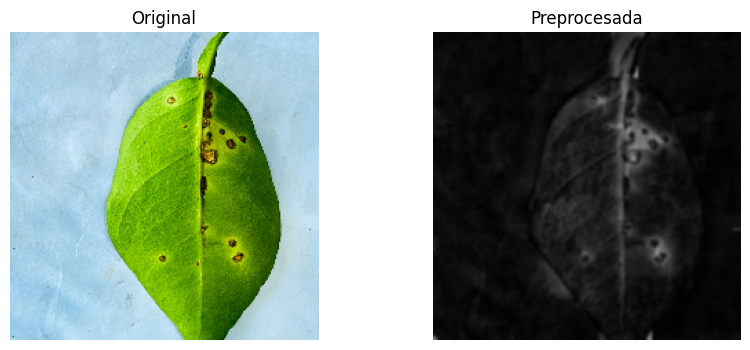

In [27]:
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    blurred = cv2.GaussianBlur(tophat, (5,5), 0)
    final = cv2.merge([blurred, blurred, blurred])
    return final

# Prueba con una imagen aleatoria
sample_path = os.path.join(DATA_DIR, CATEGORIES[0], os.listdir(os.path.join(DATA_DIR, CATEGORIES[0]))[0])
img = cv2.imread(sample_path)
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
img_preprocessed = preprocess_image(img_resized)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_preprocessed, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title("Preprocesada")
plt.axis("off")
plt.show()


# 3) Cargar todas las imágenes y preprocesarlas

In [28]:
data = []
labels = []

for idx, category in enumerate(CATEGORIES):
    folder = os.path.join(DATA_DIR, category)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        processed_img = preprocess_image(img)
        data.append(processed_img)
        labels.append(idx)

data = np.array(data) / 255.0
labels = to_categorical(labels)

print(f"Total de imágenes cargadas: {len(data)}")
print(f"Shape de las imágenes: {data[0].shape}")


Total de imágenes cargadas: 1354
Shape de las imágenes: (224, 224, 3)


# 4) Separar train/test y visualizar muestras

Tamaño del set de entrenamiento: (1083, 224, 224, 3)
Tamaño del set de prueba: (271, 224, 224, 3)


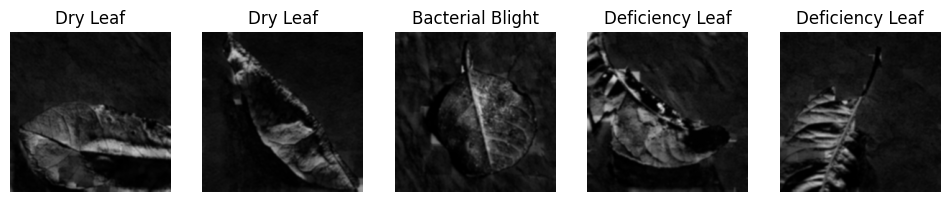

In [29]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(f"Tamaño del set de entrenamiento: {X_train.shape}")
print(f"Tamaño del set de prueba: {X_test.shape}")

# Visualización de muestras por clase
def plot_examples(X, y, n=5):
    plt.figure(figsize=(12, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        label = np.argmax(y[i])
        plt.title(CATEGORIES[label])
        plt.axis("off")
    plt.show()

plot_examples(X_train, y_train)


# 5) Aumento de datos con ImageDataGenerator

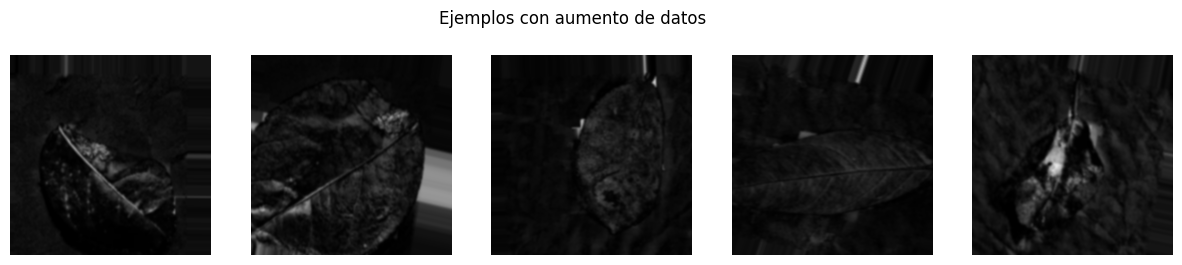

In [30]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Mostrar algunas imágenes aumentadas
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for X_batch, _ in datagen.flow(X_train, y_train, batch_size=5):
    for i in range(5):
        axs[i].imshow(X_batch[i])
        axs[i].axis("off")
    break
plt.suptitle("Ejemplos con aumento de datos")
plt.show()


# 6) Definir y compilar el modelo CNN

In [31]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CATEGORIES), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,908,553 (91.20 MB)

 Trainable params: 23,908,553 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

# 7) Entrenamiento del modelo

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=30)


Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.1608 - loss: 2.6339 - val_accuracy: 0.3210 - val_loss: 1.8450
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 253ms/step - accuracy: 0.3297 - loss: 1.8658 - val_accuracy: 0.4354 - val_loss: 1.6514
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 265ms/step - accuracy: 0.3702 - loss: 1.7302 - val_accuracy: 0.4354 - val_loss: 1.5421
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.4138 - loss: 1.6327 - val_accuracy: 0.4539 - val_loss: 1.4175
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.4045 - loss: 1.6281 - val_accuracy: 0.4982 - val_loss: 1.3999
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.4833 - loss: 1.5129 - val_accuracy: 0.5424 - val_loss: 1.3134
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.4826 - loss: 1.4254 - val_accuracy: 0.5978 - val_loss: 1.2864
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.4712 - loss: 1.4276 - val_accuracy: 0.

# 8) Evaluar y visualizar desempeño

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5795 - loss: 1.0737
Precisión en test: 60.15%


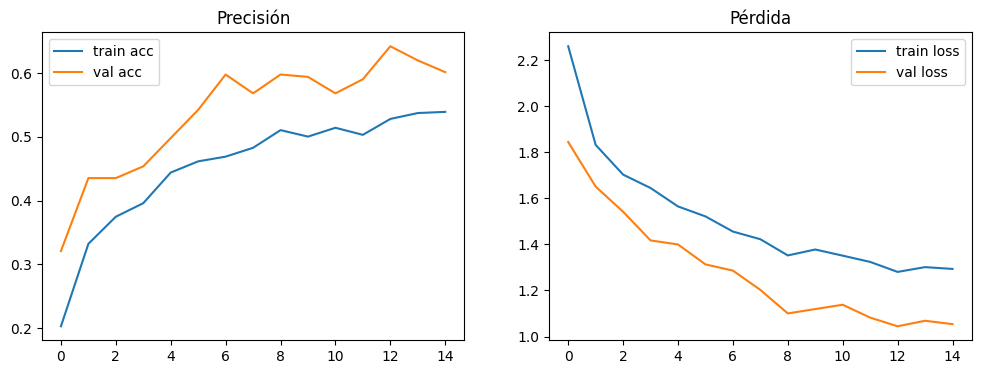

In [33]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Precisión en test: {acc * 100:.2f}%")

# Graficar curvas de pérdida y accuracy
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title("Precisión")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Pérdida")
plt.legend()

plt.show()


# 9) Probar otra arquitectura con más capas y BatchNormalization

In [34]:
from tensorflow.keras.layers import BatchNormalization

def create_improved_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(len(CATEGORIES), activation='softmax')
    ])
    return model

improved_model = create_improved_model()
improved_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
improved_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,786,825 (98.37 MB)

 Trainable params: 25,786,377 (98.37 MB)

 Non-trainable params: 448 (1.75 KB)

# 10) Entrenar el nuevo modelo

In [35]:
history2 = improved_model.fit(datagen.flow(X_train, y_train, batch_size=32),
                              validation_data=(X_test, y_test),
                              epochs=15)


Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 18s 498ms/step - accuracy: 0.2711 - loss: 25.6075 - val_accuracy: 0.0849 - val_loss: 75.1193
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 480ms/step - accuracy: 0.2765 - loss: 7.6977 - val_accuracy: 0.0849 - val_loss: 62.2512
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 481ms/step - accuracy: 0.1895 - loss: 2.5076 - val_accuracy: 0.0849 - val_loss: 35.0639
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 478ms/step - accuracy: 0.2093 - loss: 2.2122 - val_accuracy: 0.0849 - val_loss: 29.1373
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 16s 478ms/step - accuracy: 0.2226 - loss: 2.1853 - val_accuracy: 0.0996 - val_loss: 10.8801
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 496ms/step - accuracy: 0.2235 - loss: 2.1210 - val_accuracy: 0.1070 - val_loss: 9.6536
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 484ms/step - accuracy: 0.2186 - loss: 2.0729 - val_accuracy: 0.0886 - val_loss: 7.7113
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 17s 497ms/step - accuracy: 0.2174 - loss: 2.0238 - va

# 11) Evaluación y comparación

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.2419 - loss: 4.7473
Nueva precisión en test: 24.35%


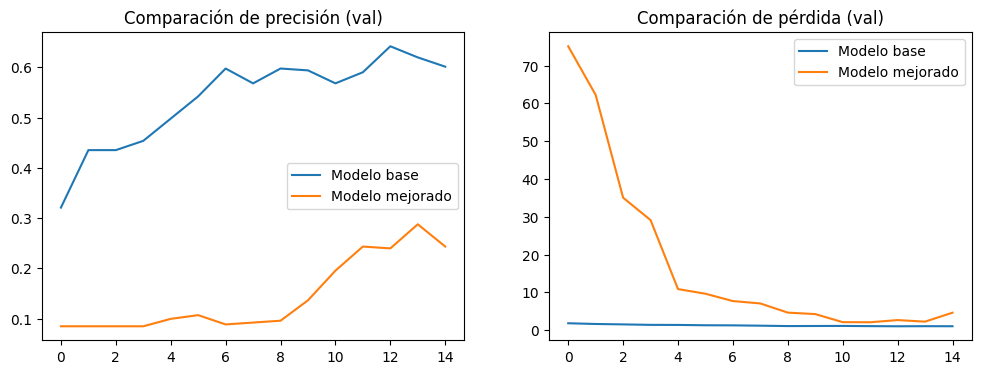

In [36]:
loss2, acc2 = improved_model.evaluate(X_test, y_test)
print(f"Nueva precisión en test: {acc2 * 100:.2f}%")

# Comparar curvas con el modelo anterior
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['val_accuracy'], label='Modelo base')
plt.plot(history2.history['val_accuracy'], label='Modelo mejorado')
plt.title("Comparación de precisión (val)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='Modelo base')
plt.plot(history2.history['val_loss'], label='Modelo mejorado')
plt.title("Comparación de pérdida (val)")
plt.legend()
plt.show()


# 12) Probar otras funciones de activación y optimizador

In [37]:
def create_model_with_elu():
    model = Sequential([
        Conv2D(32, (3,3), activation='elu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='elu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='elu'),
        Dropout(0.5),
        Dense(len(CATEGORIES), activation='softmax')
    ])
    return model

model_elu = create_model_with_elu()
model_elu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_elu = model_elu.fit(datagen.flow(X_train, y_train, batch_size=32),
                            validation_data=(X_test, y_test),
                            epochs=15)

loss_elu, acc_elu = model_elu.evaluate(X_test, y_test)
print(f"🟦 Precisión con activación ELU: {acc_elu * 100:.2f}%")


Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.1741 - loss: 4.7593 - val_accuracy: 0.3690 - val_loss: 1.8170
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.3569 - loss: 1.8838 - val_accuracy: 0.3801 - val_loss: 1.6603
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.3899 - loss: 1.7244 - val_accuracy: 0.4133 - val_loss: 1.6438
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.3843 - loss: 1.6640 - val_accuracy: 0.4539 - val_loss: 1.4595
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.4357 - loss: 1.6238 - val_accuracy: 0.4760 - val_loss: 1.4713
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - accuracy: 0.4376 - loss: 1.5992 - val_accuracy: 0.4613 - val_loss: 1.4541
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.4300 - loss: 1.5897 - val_accuracy: 0.4945 - val_loss: 1.3996
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.4457 - loss: 1.5042 - val_accuracy: 0

# 13) Probar otro optimizador como RMSprop

In [38]:
model_rmsprop = create_model_with_elu()
model_rmsprop.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

history_rmsprop = model_rmsprop.fit(datagen.flow(X_train, y_train, batch_size=32),
                                    validation_data=(X_test, y_test),
                                    epochs=15)

loss_rms, acc_rms = model_rmsprop.evaluate(X_test, y_test)
print(f"Precisión con RMSprop: {acc_rms * 100:.2f}%")


Epoch 1/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - accuracy: 0.2057 - loss: 6.2463 - val_accuracy: 0.2731 - val_loss: 1.9487
Epoch 2/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - accuracy: 0.3142 - loss: 2.0168 - val_accuracy: 0.4133 - val_loss: 1.6112
Epoch 3/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.3213 - loss: 2.0477 - val_accuracy: 0.4133 - val_loss: 1.6758
Epoch 4/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.3742 - loss: 1.7528 - val_accuracy: 0.4613 - val_loss: 1.5127
Epoch 5/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.3794 - loss: 1.7879 - val_accuracy: 0.3616 - val_loss: 1.9515
Epoch 6/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.3704 - loss: 1.7700 - val_accuracy: 0.4686 - val_loss: 1.5140
Epoch 7/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.4034 - loss: 1.7130 - val_accuracy: 0.3838 - val_loss: 1.5476
Epoch 8/15
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.4210 - loss: 1.6774 - val_accuracy: 0.

# 14) Comparación final

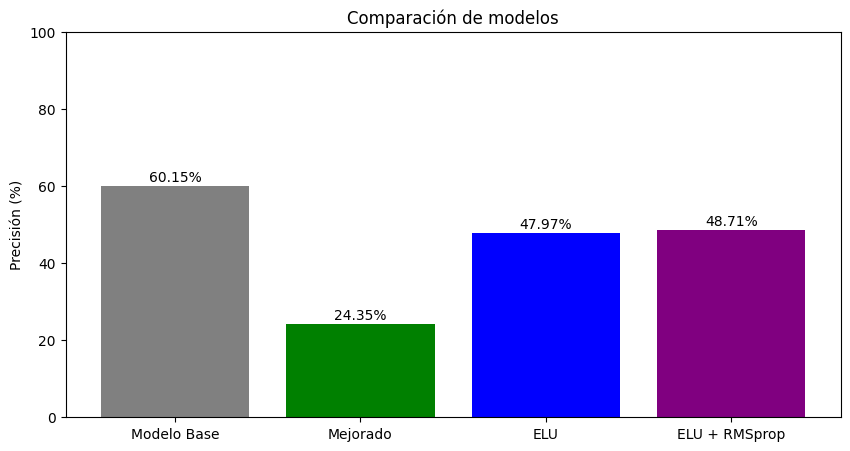

In [39]:
models_names = ["Modelo Base", "Mejorado", "ELU", "ELU + RMSprop"]
accuracies = [acc, acc2, acc_elu, acc_rms]

plt.figure(figsize=(10,5))
plt.bar(models_names, [a * 100 for a in accuracies], color=['gray', 'green', 'blue', 'purple'])
plt.ylabel("Precisión (%)")
plt.title("Comparación de modelos")
plt.ylim(0, 100)
for i, a in enumerate(accuracies):
    plt.text(i, a * 100 + 1, f"{a*100:.2f}%", ha='center')
plt.show()


In [40]:
'''
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuraciones
IMG_SIZE = 224
DATA_DIR = "dataset/"
CATEGORIES = os.listdir(DATA_DIR)

# Preprocesamiento con filtro Top-hat + Gaussiano
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    blurred = cv2.GaussianBlur(tophat, (5,5), 0)
    final = cv2.merge([blurred, blurred, blurred])  # Convert to 3-channel
    return final

# Carga y preprocesamiento
data = []
labels = []

for idx, category in enumerate(CATEGORIES):
    folder = os.path.join(DATA_DIR, category)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        processed_img = preprocess_image(img)
        data.append(processed_img)
        labels.append(idx)

data = np.array(data) / 255.0
labels = to_categorical(labels)

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Aumento de datos
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Modelo CNN básico
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CATEGORIES), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=15)

# Evaluación final
loss, acc = model.evaluate(X_test, y_test)
print(f"Precisión en test: {acc * 100:.2f}%")
'''

'\nimport os\nimport cv2\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.model_selection import train_test_split\nfrom tensorflow.keras.utils import to_categorical\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout\nfrom tensorflow.keras.preprocessing.image import ImageDataGenerator\n\n# Configuraciones\nIMG_SIZE = 224\nDATA_DIR = "dataset/"\nCATEGORIES = os.listdir(DATA_DIR)\n\n# Preprocesamiento con filtro Top-hat + Gaussiano\ndef preprocess_image(img):\n    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\n    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15,15))\n    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)\n    blurred = cv2.GaussianBlur(tophat, (5,5), 0)\n    final = cv2.merge([blurred, blurred, blurred])  # Convert to 3-channel\n    return final\n\n# Carga y preprocesamiento\ndata = []\nlabels = []\n\nfor idx, category in enumerate(CATEGORIES):\n    folder = os.p